In [1]:
using Pipe
using DataFrames
# using StatsPlots
using CSV
# using RollingFunctions
using Query
# using GLMakie

using JSON
using DataFrames
using Dates
using Colors
# using ColorSchemes
using Indicators

import Colors
using Plots
using Interact
using Statistics
using StatsBase

include("utils.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-198979350612550823\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6526713541174850209\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-198979350612550823\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

calc_wavelet (generic function with 1 method)

In [18]:
json_data_folder = "../user_data/data/binance"
json_filename = "ADA_USDT-1m.json"
json_filepath = "$json_data_folder/$json_filename"
f = open(json_filepath, "r")
json_data = JSON.parse(f)
close(f)

dfa = DataFrame(unix_time = Int64[], open=Float64[], high=Float64[], low=Float64[], close=Float64[], volume=Float64[])
for r in json_data push!(dfa, r) end
dfa.unix_time .= dfa.unix_time ./1000
# dfa.time .= unix2datetime.(dfa.unix_time)

insertcols!(dfa, :time => unix2datetime.(dfa.unix_time))
nrow(dfa)

228592

In [19]:
start_date = DateTime(2021, 1, 1)
end_date = DateTime(2021, 5, 15)
vdf = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]
ut, tt, hh, ll, cc, oo = vdf.unix_time, vdf.time, vdf.high, vdf.low, vdf.close, vdf.open
length(tt)

192358

In [4]:
# first(dfa,5)

In [14]:
function backtest(stopsl, targetsl, lagLs, lagLsl, tplagHs, tplagHsl, cooloffsl, tracksl)
#     println("$sl_slider, $lg_thresh_slider, $tp_slider")
    capital = 10000.
    qfee = 0.001
    risk_percent = 0.01
    

    dfo = DataFrame(ut = Int64[], 
            tt = DateTime[],
            order = Symbol[],
            oix = Int64[],
            reason = Symbol[],
            price = Float64[],
            target = Float64[],
            stop = Float64[],
            qty = Float64[],
            pnl = Float64[],
            capital = Float64[]
        )

    push!(dfo, (ut = ut[1], tt=tt[1], oix =0, order = :long, reason = :init, price = 0, stop = 0, target=0,
                qty = 0, pnl = 0, capital = capital))


    in_long_pos = false 
    qlsellsig = 1.01
    qstop = 0.01
    in_i = 0
    for i in Int64(max(lagLsl, tplagHsl)):length(cc)

        ord = last(dfo)
        if !in_long_pos
            if true &&
#                 (i - ord.oix > cooloffsl) &&
                cc[i-1] < lagLs[i-2] && cc[i] > oo[i] &&
                tplagHs[i] > cc[i] * (1+targetsl/100)
                
                target = cc[i] * (1+targetsl/100)
#                 stop_price = cc[i] * (1 - sl_slider/100)
                stop_price = cc[i] * (1 - stopsl/100)

                risk_size = capital * risk_percent

                buy_price = cc[i]*(1+qfee)

                risk_price_range = (buy_price - stop_price)
                buyq = risk_size / risk_price_range


                push!(dfo, (ut = ut[i], tt=tt[i], oix=i, order = :long, reason = :enter, price = buy_price, qty = buyq,
                        stop = stop_price, target=target, pnl = 0, capital = capital))

                in_long_pos = true
            end
        else
            sell = false
            sell_price = 0
            if hh[i] >= ord.target
                sell_price = ord.target*(1-qfee)
                sell = true
            elseif ll[i] <= ord.stop
                sell_price = ord.stop*(1-qfee)
                sell = true
            end
            
            if sell
                profit_loss = ord.qty * (sell_price - ord.price)
                capital = capital + profit_loss

                push!(dfo, (ut = ut[i], tt=tt[i], oix=i, order = :long, reason = :exit, price = sell_price, stop = 0, target=0,
                         qty = ord.qty, pnl = profit_loss, capital = capital))

                in_long_pos = false
            end
           

        end
    #     println(capital)

    end
    CSV.write("trades.csv", dfo)
    dfo
end

backtest (generic function with 1 method)

In [15]:
100 % 20
# 1

0

In [25]:
arlen = length(cc)
wsl = window_slider(arlen, subs=1); 
wst = Interact.@map first(&wsl)
wed = Interact.@map last(&wsl)
plot_box = Observable{Any}(dom"div"())
res_box = Observable{Any}(dom"div"())
rng = Interact.@map &wst: &wed
# wcc = Interact.@map cc[&rng]
# wll = Interact.@map ll[&rng]

# wut = Interact.@map ut[&rng]
# wtt = Interact.@map tt[&rng]

lagLsl = slider(1:20:900; label="lagL", default=14); lagLsl[] = 300;
lagLs = Interact.@map  [fill(ll[1], &lagLsl)..., [minimum(ll[i-&lagLsl:i]) for i in &lagLsl+1:arlen]...]

tplagHsl = slider(0:5:600; label="lagTpH", default=14); tplagHsl[] = 30;
tplagHs = Interact.@map  [fill(hh[1], &tplagHsl)..., [maximum(hh[i-&tplagHsl:i]) for i in &tplagHsl+1:arlen]...]

cooloffsl = slider(0:5:600; label="cool", default=30); cooloffsl[]=30;
tracksl = slider(0:5:600; label="track", default=30); tracksl[]=30;

# lagHsl = slider(1:20:1200; label="lagH", default=14); lagHsl[] = 600;
# lagHs = Interact.@map  [fill(hh[1], &lagHsl)..., [maximum(hh[i-&lagHsl:i]) for i in &lagHsl+1:arlen]...]

# wlagLs = Interact.@map (&lagLs)[&rng]
# wlagHs = Interact.@map (&lagHs)[&rng]

stopsl = slider(0:0.1:5; label="stop", default=14); stopsl[] = 2;
targetsl = slider(0:0.1:10; label="tgt", default=14); targetsl[] = 1;

# &negated_slider, &cooloff_slider, &ema_1_trans, &ema_1_ch, &ema_2_trans, &ema_2_ch
dfo = Interact.@map backtest(&stopsl, &targetsl, &lagLs, &lagLsl, &tplagHs, &tplagHsl, &cooloffsl, &tracksl )

function get_results(dfo)
    buys = filter(row -> row.reason == :enter, dfo)
    losses = filter(row -> row.reason == :exit && row.pnl < 0, dfo)
    profits = filter(row -> row.reason == :exit && row.pnl > 0, dfo)
    no_losses = nrow(losses)
    no_profits = nrow(profits)
    tot_losses = Int(trunc(sum((losses).pnl)))
    tot_profits = Int(trunc(sum((profits).pnl)))
    (buys,losses,profits,no_losses,no_profits,tot_losses,tot_profits)
end

function draw_it_all(rng, lagLs, tplagHs, dfo)
    wut = ut[rng]
    if length(wut) == 0 return end
    
    wlagLs = lagLs[rng]
    wtplagHs = tplagHs[rng]
    (buys,losses,profits,no_losses,no_profits,tot_losses,tot_profits) = get_results(dfo)
    wdfo = filter(row -> (row.ut >= first(wut) && row.ut <= last(wut)), dfo, view=false)
    (wbuys,wlosses,wprofits,wno_losses,wno_profits,wtot_losses,wtot_profits) = get_results(wdfo)
    
    f2 = plot(wut, cc[rng], size=(1500,600))
    plot!(wut, ll[rng], lw=0.5)
    plot!(wut, wlagLs)
    plot!(wut, wtplagHs)
#     plot!(wlagHs)
    plot!(wut, wlagLs .* 0.995, fillrange=wlagLs*1.005, lw=0, fillalpha=0.15)
    
    
    if nrow(wbuys) > 0  vline!(wbuys.ut,lw=0.5, color=:blue); scatter!(wbuys.ut, wbuys.price, markersize=2, color=:blue) end
    if nrow(wprofits) > 0 vline!(wprofits.ut,lw=0.5, color=:green); scatter!(wprofits.ut, wprofits.price, markersize=2, color=:green) end
    if nrow(wlosses) > 0 vline!(wlosses.ut,lw=0.5, color=:red); scatter!(wlosses.ut, wlosses.price, markersize=2, color=:red) end
#     plot!(wlag2mins)
    dom"div"( 
            dom"span"(
                (no_losses,no_profits,tot_losses,tot_profits,tot_losses+tot_profits),
                (wtot_losses,wtot_profits,wtot_profits+wtot_losses)),
            f2) 
end
# , wbuys, wlosses, wprofits
map!(draw_it_all, plot_box, rng, lagLs, tplagHs, dfo)
ui = dom"div"(
        hbox(lagLsl,stopsl,targetsl,tplagHsl,cooloffsl),
        hbox(tracksl),
        plot_box,wsl
    )
tplagHsl[]=50
# lagLsl[] = 300
wsl[:log2_slider][] = 11
# tracksl = 30
tplagHsl[] = 20
cooloffsl[]=60
targetsl[] = 4
# wsl[:log2_slider][] = 11
# lagsl[] = 14
ui





(div
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["lagL"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 45, :default => 14, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :min => 1, :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
16, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013a746a90, Task (runnable) @0x000000013a746a90), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"21\",\"41\",\"61\",\"81\",\"101\",\"121\",\"141\",\"161\",\"181\",\"201\",\"221\",\"241\",\"261\",\"281\",\"301\",\"321\",\"341\",\"361\",\"381\",\"401\",\"421\",\"441\",\"461\",\"481\",\"501\",\

┌ Warning: A rendered observable (scopeid=11438588943448507233, obs.id=887138605382235131) changed from a WebIO node to Nothing.
└ @ WebIO /Users/johnsmith/.julia/dev/WebIO/src/render.jl:104


MethodError: MethodError: [0mCannot `convert` an object of type [92mNothing[39m[0m to an object of type [91mNode{WebIO.DOM}[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::T[39m) where T at essentials.jl:205

In [21]:
2^13 /60/24

5.688888888888889

In [22]:
log2(60*24*30)

15.398743691938193

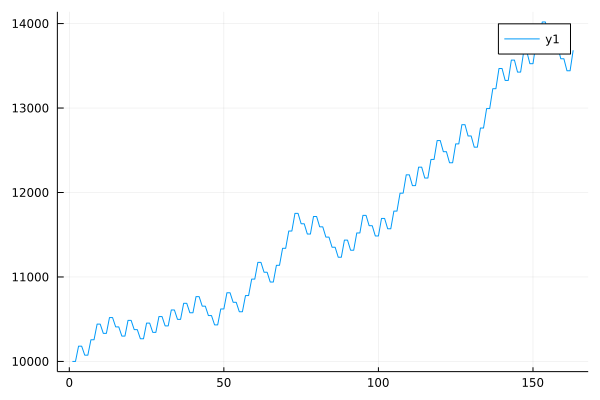

In [26]:
plot(dfo[].capital)